# 1. Intoduction

Regression is an interesting technique of estimating the
values among variables. In this project, we are going to implement
and test regression by maximum
likelihood estimation criteria using the gaussian function as a
basis function to fit random noisy data we will generate, that
represent the cosine function (plus noise).

We will implement this basic model from scratch.
All the math will be done using
the numpy library only. The sklearn library will only be used to
split the data into a training and test set and for Gaussian Mixture Modelling.


# 2. Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import random
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as GMM

# 3. Generating the dataset

* So we will generate 1000 points for our x variable in range x=(0,3).
* The target variable will be cosine of x variable plus noise

Text(0, 0.5, 'Target (t)')

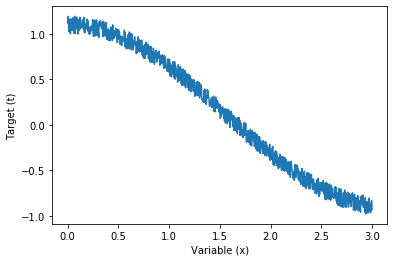

In [2]:
# Generate data

f = 1/1000
sample = 1000
x_points = np.linspace(0, 3, num=1000)
noise = 0.0002*np.asarray(random.sample(range(0,1000),sample))
y_points = np.cos(x_points) + noise
plt.plot(x_points,y_points)
plt.xlabel('Variable (x)')
plt.ylabel('Target (t)')

# 4. Pre processing the data

We will take here the train test split to be 0.2. Later on you can change it to see its effect.

In [3]:
# create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(x_points, y_points, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800,) (800,)
(200,) (200,)


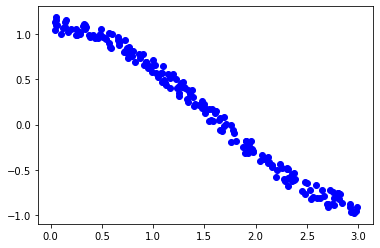

In [4]:
# plot desired data

plt.scatter(X_test, y_test, color='blue')

First we are going to implement the model using below given set of parameters. Afterwards you can adjust the parameters accordingly to see their effect on model performance. 

In [5]:
# print important info

m = len(X_train)
print('# of training samples:', m)
max_iterations = 1000
print('# of max iterations:', max_iterations)
learning_rate = 1e-1
print('learning rate:', learning_rate)

# of training samples: 800
# of max iterations: 1000
learning rate: 0.1


# 5. Model Building

## Gaussian Distribution

Since our data is uniformly distributed which is sometimes called normal or gaussian distribution. It has a bell-shaped curve, with the data points symmetrically distributed around the mean value.
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/gaussians.png">

also so the pdf (probablity density function) we would use will be of the form:-

<img src ="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/pdf_var-1-300x81.png">

where μ is the mean and σ2 is the variance.

## Gaussian Radial Basis Function

In this project as we stated above we are going to use Gaussian radial basis function for our linear regression implementation.

* Radial functions are a special class of function Their characteristic feature is that their response decreases or increases monotonically with distance from a central point The centre the distance scale and the precise shape of the radial function are parameters of the model all fixed if it is linear.The whole process of this model is shown in image below-
<img src="https://miro.medium.com/max/1278/1*c6KMMqfhmXdJda9LBGmhJw.png">


Its parameters are its centre c and its radius r.



## Linear Regression

• Linear combination of input features

\begin{align}
y(x,w) & =w_0 + w_1 x_1 + .... + w_D x_D
\end{align}

with x = (x1, . . . , xD)

• Linear function of parameters w

• Linear function of features x. Extension to linear combination of base
functions

\begin{align}
y(x,w) & =w_0 + \sum_{j=1}^M w_j P_j(x)
\end{align}

where M is the no. of clusters in input data

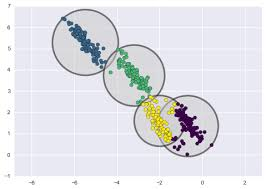

where P is called parametrization matrix
$$
\mathbf{P}
=
\begin{bmatrix}
p_0(x_1) & p_1(x_1) & \cdots &
p_m(x_1) \\
p_0(x_2) & p_1(x_2) & \cdots &
p_m(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
p_0(x_D) & p_1(x_D) & \cdots &
p_m(x_D) \\
\end{bmatrix}
$$

This matrix corresponds to the basis functions applied to
all the points in the data. Each column corresponds to on
weight value in the vector w, and each row corresponds to
a point in the data.Once all the basis functions represented
by ps are calculated, we take this matrix and plug it into the
following equation to get our final values of w:


\begin{align}
w & = (P^T P)^{-1} P^T y
\end{align}

So to summarize below given are the steps that we need to perform in this project-
* Determine the optimal no. of clusters of our data using Gaussian Mixture Modelling Clustering.
* After finding the optimal no. of clusters we would find the centers of these clusters.
* Then initailize weight vector with M random weights.
* And then we will build our parametrization matrix. 
* At last we would optimize log Likelihood function (that is least squares method) to reduce the losses and find the optimal weights for our model and predict our target variable using the above given radial basis function, the centers and the optimal weights( in this step for simplicity purpose of this model and not involve more complex mathematics we will drop the division of variance or(radius) term in the exponent from the rbf function.

## Determing optimal no. of clusters using distance between train and test GMMs

In [6]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [7]:
# calculating the distance between training and test data with the given no. of clusters

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [8]:
# reshaping our data

X_train=np.reshape(X_train,(-1,1))
X_test=np.reshape(X_test,(-1,1))

In [9]:
# using Gaussian Mixture Modelling to find distance between training and test data predictions for given no. of clusters

n_clusters=np.arange(2, 20)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):        
        gmm_train=GMM(n, n_init=2).fit(X_train) 
        gmm_test=GMM(n, n_init=2).fit(X_test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

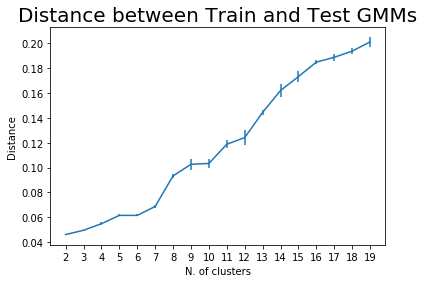

In [10]:
# plotting the distance for different clusters

plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

As we can see that the distance is minimum for 3 clusters so we would use 3 clusters for our model.

## Finding centers of these clusters

In [11]:
# finding the centers of all the clusters 

gmm = GMM(n_components=3)
gmm.fit(X_train)

# printing gmm_means and their shape

print(gmm.means_.shape)
print("\n", gmm.means_)

# storing all the mean values in the list centres

centers=[gmm.means_[0][0] , gmm.means_[1][0] , gmm.means_[2][0]]

(3, 1)

 [[1.55496423]
 [2.50999349]
 [0.52466977]]


## Initializing the weights

In [12]:
# initializing random weights in range(0,1) in the list w  and then printing it and its length 

w = [random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)]
print(w,len(w))

[0.7712406844423432, 0.4421309244965851, 0.09347238020837834] 3


## Building parametrization matrix

In [13]:
# flattening our test and train datasets for further calculations

X_train=X_train.flatten()
X_test=X_test.flatten()
X_train.shape,X_test.shape

((800,), (200,))

In [14]:
# we build the P matrix (big phai)

p_0 = np.exp(-((X_train-centers[0])**2))
p_0 = np.reshape(p_0, (-1, 1))
p_1 = np.exp(-((X_train-centers[1])**2))
p_1 = np.reshape(p_1, (-1, 1))
p_2 = np.exp(-((X_train-centers[2])**2))
p_2 = np.reshape(p_2, (-1, 1))
P = np.hstack((p_0, p_1, p_2))
print(P.shape)

(800, 3)


## Finding optimal weights and predicting target variable

In [15]:
# we do the linear algebra to find the weights

w = np.matmul(np.matmul(np.linalg.inv(np.matmul(P.T, P)), P.T), y_train)

In [16]:
# we define the basis function and y_hat

y_hat = lambda x: w[2]*np.exp(-((x-centers[2])**2)) + w[1]*np.exp(-((x-centers[1])**2)) + w[0]*np.exp(-((x-centers[0])**2)) # lambda expression for future use, represents the line equation

In [17]:
# cost function
cost = np.square(np.linalg.norm(y_hat(X_train)-y_train))

In [18]:
# printing the optimal weights

print(w)



[ 0.06950187 -0.77954058  1.0017428 ]


In [19]:
# predicting our target variable using test data

y_predicted = [y_hat(x) for x in X_test]
y_predicted = np.array(y_predicted)

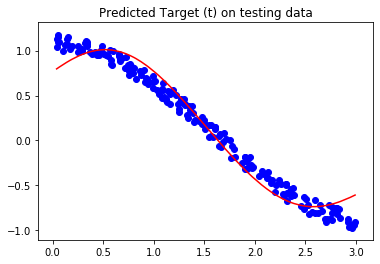

Root-Mean-Square Error: 0.03757421274638709


In [20]:
# Plotting our prediction vs original target variable
# printing the RMS error

ind = np.argsort(X_test)
ind = ind.ravel()
plt.title('Predicted Target (t) on testing data')
plt.plot(X_test[ind], y_predicted[ind], color='red')
plt.scatter(X_test[ind], y_test[ind], color='blue')
plt.show()
cost_test = np.square(np.linalg.norm(y_predicted - y_test))*2/len(X_test)
print('Root-Mean-Square Error:', cost_test)

# 6. Conclusion

In [21]:
# Write your conclsuions here